In [1]:
import os, json, csv
from shapely import wkt
import numpy as np
import rasterio
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
def convert_tiff_to_jpg_satellite(
    input_tif_path, 
    output_jpg_path, 
    band_order=(1, 2, 3),
    min_percent=2,    # Lower cut for stretch
    max_percent=98    # Upper cut for stretch
):
    """
    Convert a multi-band satellite TIFF to an 8-bit RGB JPEG.
    - band_order: Which bands to use for R, G, B (1-based).
    - min_percent, max_percent: The percentile cuts for min/max stretching.
    
    If your satellite data is 4+ bands (e.g., RGBA or R, G, B, NIR),
    you can specify which 3 to pick for R, G, B. 
    e.g. band_order=(3, 2, 1) might give you a natural color 
    if your GeoTIFF is B, G, R, NIR in that order.
    """

    with rasterio.open(input_tif_path) as src:
        # Read the specified bands into numpy arrays
        arrs = [src.read(b).astype(np.float32) for b in band_order]
        # Stack into shape (height, width, 3)
        rgb = np.dstack(arrs)
        
        # Optionally stretch the data for display
        # 1) Flatten to get global stats across all 3 channels
        flat = rgb.flatten()
        # Remove NaN or no-data (if any)
        flat = flat[~np.isnan(flat)]
        
        # 2) Compute chosen percentile range
        min_val = np.percentile(flat, min_percent)
        max_val = np.percentile(flat, max_percent)

        # 3) Clip, then scale to [0..255]
        rgb = np.clip(rgb, min_val, max_val)
        rgb = ( (rgb - min_val) / (max_val - min_val + 1e-6) ) * 255.0
        
        # Convert to uint8
        rgb_8 = rgb.astype(np.uint8)
        
        # Save to JPEG using Pillow
        img = Image.fromarray(rgb_8, mode='RGB')
        img.save(output_jpg_path, 'JPEG')

        print(f"Saved {output_jpg_path}")

def batch_tiff_to_jpg_satellite(
    input_dir, 
    output_dir, 
    band_order=(1, 2, 3)
):
    """
    Loop over a directory of TIFFs and convert each to JPEG,
    picking the desired band_order and using default stretch params.
    """
    os.makedirs(output_dir, exist_ok=True)
    for fname in os.listdir(input_dir):
        if fname.lower().endswith(('.tif', '.tiff')):
            in_path = os.path.join(input_dir, fname)
            base = os.path.splitext(fname)[0]
            out_path = os.path.join(output_dir, f"{base}.jpg")
            convert_tiff_to_jpg_satellite(
                in_path, out_path, band_order=band_order
            )

In [4]:
def json_to_bboxes(input_json_dir, output_csv_dir):
    """
    For each JSON in input_json_dir, parse the bounding boxes from
    the polygon WKT. Output a CSV with (feature_type, x_min, y_min, x_max, y_max).
    """
    os.makedirs(output_csv_dir, exist_ok=True)
    
    for filename in os.listdir(input_json_dir):
        if filename.lower().endswith('.json'):
            input_path = os.path.join(input_json_dir, filename)

            # Read JSON
            with open(input_path, 'r') as f:
                data = json.load(f)
            
            # The “xy” key in features holds the polygon data
            if "features" not in data or "xy" not in data["features"]:
                # If no polygons, skip or write an empty CSV
                print(f"No 'xy' found in {filename}. Skipping or creating empty CSV.")
                continue
            
            # Prepare output CSV
            base_name = os.path.splitext(filename)[0]
            output_csv_path = os.path.join(output_csv_dir, f"{base_name}.csv")
            
            with open(output_csv_path, 'w', newline='') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(["feature_type", "x_min", "y_min", "x_max", "y_max"])
                
                # Iterate over polygons
                for poly_info in data["features"]["xy"]:
                    # Read the feature_type
                    feature_type = poly_info["properties"]["feature_type"]
                    
                    # Parse the WKT
                    polygon = wkt.loads(poly_info["wkt"])
                    
                    # Get the bounding box (minx, miny, maxx, maxy)
                    minx, miny, maxx, maxy = polygon.bounds
                    
                    # Write row to CSV
                    writer.writerow([
                        feature_type,
                        f"{minx:.3f}",
                        f"{miny:.3f}",
                        f"{maxx:.3f}",
                        f"{maxy:.3f}"
                    ])
            
            print(f"Created CSV: {output_csv_path}")


In [6]:
def display_image_with_bboxes(image_path, csv_path):
    """
    Show the image at image_path, then read the bounding boxes from csv_path
    and draw them on top of the image.
    """
    # Open the image
    img = Image.open(image_path)
    
    # Create a matplotlib figure
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img)
    
    # Read bounding boxes
    with open(csv_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            feature_type = row["feature_type"]
            x_min = float(row["x_min"])
            y_min = float(row["y_min"])
            x_max = float(row["x_max"])
            y_max = float(row["y_max"])
            
            # Width and height of the bounding box
            width = x_max - x_min
            height = y_max - y_min
            
            # Create a rectangle patch
            rect = patches.Rectangle(
                (x_min, y_min),
                width,
                height,
                linewidth=2,
                edgecolor='red',
                facecolor='none'
            )
            
            ax.add_patch(rect)
            
            # (Optional) Add text label
            #ax.text(
            #    x_min, y_min - 2,
            #    feature_type,
            #    color='red',
            #    fontsize=10,
            #    backgroundcolor='white'
            #)
    
    plt.title(f"Image with bounding boxes\n{image_path}")
    plt.axis('off')
    plt.show()

# Usage:
# display_image_with_bboxes(
#     image_path='/path/to/your.jpg',
#     csv_path='/path/to/your.csv'
# )


In [18]:
main_folder = './giant_geotiff/xview2_geotiff/geotiffs/hold'

batch_tiff_to_jpg_satellite(
    input_dir=main_folder+'/images/',
    output_dir=main_folder+'/transform_phase01/images/',
    band_order=(1, 2, 3)  # Or (3, 2, 1), etc., depending on your data
)

json_to_bboxes(
    input_json_dir=main_folder+'/labels/',
    output_csv_dir=main_folder+'/transform_phase01/labels/'
)

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/santa-rosa-wildfire_00000108_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-matthew_00000294_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000717_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/midwest-flooding_00000341_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00001277_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-matthew_00000131_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000047_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000081_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/midwest-flooding_00000245_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000505_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000081_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000743_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/midwest-flooding_00000097_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-matthew_00000299_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/santa-rosa-wildfire_00000261_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-michael_00000317_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geo

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-harvey_00000199_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000453_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/midwest-flooding_00000180_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000154_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/midwest-flooding_00000250_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00001068_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000162_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00001276_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000006_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00001290_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-michael_00000433_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000896_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00001094_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-michael_00000006_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/midwest-flooding_00000101_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-harvey_00000014_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/trans

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/midwest-flooding_00000364_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000295_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/midwest-flooding_00000124_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/palu-tsunami_00000130_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/midwest-flooding_00000425_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000090_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000315_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-matthew_00000323_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/ho

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/santa-rosa-wildfire_00000037_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/mexico-earthquake_00000060_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-matthew_00000081_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000305_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-harvey_00000421_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000351_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/midwest-flooding_00000069_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/mexico-earthquake_00000134_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotif

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000175_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-matthew_00000127_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000761_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-matthew_00000218_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-matthew_00000224_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000487_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-michael_00000425_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000447_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geo

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-matthew_00000292_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00001002_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000391_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/santa-rosa-wildfire_00000316_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/midwest-flooding_00000055_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/midwest-flooding_00000118_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-matthew_00000151_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-matthew_00000194_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geoti

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/midwest-flooding_00000369_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/santa-rosa-wildfire_00000195_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000816_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000911_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00001048_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/santa-rosa-wildfire_00000062_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/santa-rosa-wildfire_00000218_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00001201_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transfo

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000342_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/santa-rosa-wildfire_00000230_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000038_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-michael_00000084_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000720_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-harvey_00000021_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/midwest-flooding_00000163_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/santa-rosa-wildfire_00000077_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-matthew_00000351_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/midwest-flooding_00000057_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-harvey_00000513_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000248_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000023_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000786_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000796_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00001015_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_ph

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-harvey_00000087_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00001026_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000539_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000465_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000239_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/santa-rosa-wildfire_00000323_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-matthew_00000138_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/mexico-earthquake_00000056_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/ge

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000802_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/mexico-earthquake_00000077_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-michael_00000194_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000848_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000570_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-matthew_00000117_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-matthew_00000258_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000385_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/tra

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/santa-rosa-wildfire_00000139_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/palu-tsunami_00000093_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-matthew_00000282_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000140_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/midwest-flooding_00000174_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/midwest-flooding_00000262_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/santa-rosa-wildfire_00000219_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-michael_00000006_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/ho

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/palu-tsunami_00000060_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000291_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-michael_00000495_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/midwest-flooding_00000226_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000284_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-harvey_00000459_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/santa-rosa-wildfire_00000349_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/palu-tsunami_00000085_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transfor

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-harvey_00000263_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-michael_00000423_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-harvey_00000457_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000067_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/mexico-earthquake_00000081_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-matthew_00000327_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-harvey_00000475_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-michael_00000456_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-michael_00000227_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/midwest-flooding_00000037_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000137_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-harvey_00000449_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-michael_00000401_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000899_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000630_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-michael_00000111_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000667_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-michael_00000374_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00001155_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/palu-tsunami_00000079_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/midwest-flooding_00000052_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/midwest-flooding_00000325_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000818_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00001187_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/i

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/santa-rosa-wildfire_00000288_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00001034_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/mexico-earthquake_00000165_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/santa-rosa-wildfire_00000227_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/santa-rosa-wildfire_00000319_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-michael_00000223_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000124_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/midwest-flooding_00000034_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000348_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000796_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-matthew_00000374_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-matthew_00000294_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000218_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/santa-rosa-wildfire_00000261_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/palu-tsunami_00000078_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000111_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transfor

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-matthew_00000266_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/santa-rosa-wildfire_00000064_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000424_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-matthew_00000074_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-harvey_00000253_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-matthew_00000253_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/midwest-flooding_00000295_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000562_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/t

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000750_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000872_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/santa-rosa-wildfire_00000263_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000023_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/midwest-flooding_00000192_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000511_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-harvey_00000110_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-harvey_00000386_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/trans

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-michael_00000432_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00001212_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/santa-rosa-wildfire_00000307_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00001290_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000350_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/santa-rosa-wildfire_00000120_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000230_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000413_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/mexico-earthquake_00000130_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-michael_00000288_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/mexico-earthquake_00000062_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-matthew_00000220_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-michael_00000376_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00001014_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000463_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/guatemala-volcano_00000012_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000155_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000532_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-harvey_00000215_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00001284_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00001342_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-matthew_00000157_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-michael_00000245_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/santa-rosa-wildfire_00000195_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/h

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-michael_00000185_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-harvey_00000362_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00001370_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/santa-rosa-wildfire_00000150_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-michael_00000173_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-harvey_00000032_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000143_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-michael_00000237_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold

Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000808_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-matthew_00000074_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000524_post_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-harvey_00000183_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/mexico-earthquake_00000116_pre_disaster.jpg
Saved ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/hurricane-florence_00000041_post_disaster.jpg
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/socal-fire_00000846_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-harvey_00000279_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_g

Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/socal-fire_00001032_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-harvey_00000095_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/socal-fire_00000736_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/santa-rosa-wildfire_00000037_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/socal-fire_00000131_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/socal-fire_00000604_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/midwest-flooding_00000134_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-matthew_00000386_pre_disaster.csv
Created

Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-harvey_00000149_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-harvey_00000513_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-florence_00000299_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/midwest-flooding_00000218_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/midwest-flooding_00000372_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-matthew_00000087_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-michael_00000131_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-florence_0000047

Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/palu-tsunami_00000039_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/socal-fire_00000120_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-florence_00000373_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-harvey_00000083_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/socal-fire_00000316_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/santa-rosa-wildfire_00000218_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/santa-rosa-wildfire_00000211_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/socal-fire_00000941_post_disaster.csv


Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/socal-fire_00000067_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/socal-fire_00000165_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-florence_00000385_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/santa-rosa-wildfire_00000332_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-harvey_00000124_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-matthew_00000055_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/santa-rosa-wildfire_00000193_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-florence_00000518_pre_dis

Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/mexico-earthquake_00000036_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-matthew_00000106_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-michael_00000054_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/midwest-flooding_00000134_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/santa-rosa-wildfire_00000029_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/palu-tsunami_00000180_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-michael_00000525_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/midwest-flooding_00000124_post

Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/santa-rosa-wildfire_00000240_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/mexico-earthquake_00000133_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/socal-fire_00001311_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-michael_00000064_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/socal-fire_00000768_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-michael_00000407_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-harvey_00000065_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-michael_00000226_post_disas

Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-michael_00000221_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/socal-fire_00000711_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/socal-fire_00000481_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-matthew_00000124_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/socal-fire_00000324_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-florence_00000521_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/socal-fire_00000380_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/socal-fire_00000182_post_disaster.csv
Created CSV: .

Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/socal-fire_00001174_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/socal-fire_00000814_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/socal-fire_00000147_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/santa-rosa-wildfire_00000083_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-matthew_00000391_post_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/hurricane-harvey_00000188_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/socal-fire_00000860_pre_disaster.csv
Created CSV: ./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/socal-fire_00000189_pre_disaster.csv
Created CSV: ./g

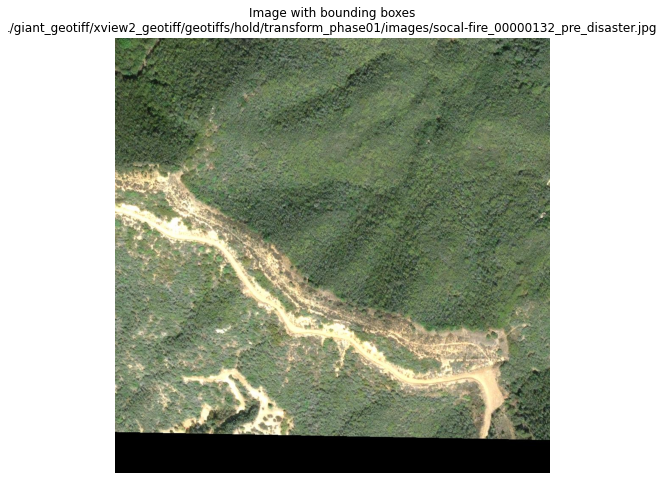

In [20]:
display_image_with_bboxes(
    image_path='./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/images/socal-fire_00000132_pre_disaster.jpg',
    csv_path='./giant_geotiff/xview2_geotiff/geotiffs/hold/transform_phase01/labels/socal-fire_00000132_pre_disaster.csv'
)